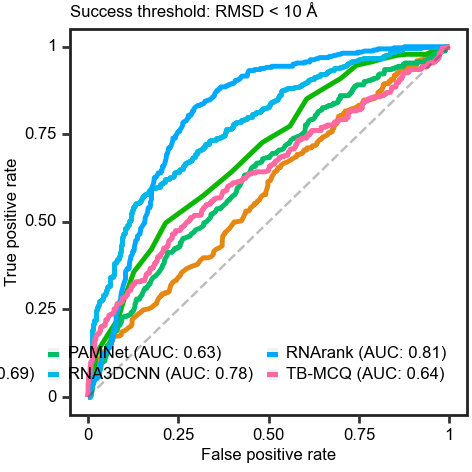

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.36 x 2.36 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/ROC_deep_learning_metrics_RMSD_as_label.pdf


In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
ROC curve comparison for RNA 3D model scoring metrics.

This script:
1) Loads merged benchmark metrics (dataset1 + dataset2)
2) Defines a binary success label using an RMSD threshold (default: RMSD < 10 Å)
3) Computes ROC curves and AUC for selected metrics
4) Plots all ROC curves on a single panel (Nature-style small figure) and saves as PDF

Notes
-----
- Some metrics are "higher is better" (e.g., LociPARSE, RNArank),
  while others are "lower is better" (e.g., energy-based potentials).
  We convert all metrics so that larger scores always mean better models
  by multiplying by +1 or -1 accordingly.

Requirements
------------
pandas, numpy, scikit-learn, plotnine
"""

from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_curve, auc
from plotnine import (
    ggplot, aes, geom_line, theme, element_rect, element_line, element_text,
    labs, ggtitle, scale_color_manual
)

# -------------------------
# Input / Output
# -------------------------
DATASET1 = Path("../results/metrics/dataset1_merge.csv")
DATASET2 = Path("../results/metrics/dataset2_merge.csv")
OUT_PDF = Path("../figures/ROC_deep_learning_metrics_RMSD_as_label.pdf")

# -------------------------
# Figure style (Nature-like small panel)
# -------------------------
BLACK = "#222222"
GRAY = "#666666"

FIGSIZE_IN = (2.36, 2.36)  # inches
FONT = "Arial"
FONTSIZE = 6

# Colors (match your original order)
# Tip: keep colors stable across figures for consistency in the paper.
COLOR_LIST = ["#E68613", "#0BB702", "#00BE67", "#00B8E7", "#00A9FF", "#FF68A1"]

# -------------------------
# Column label normalization (optional; for publication names)
# -------------------------
COLUMN_RENAME = {
    "INF-ALL": "INF",
    "f1": "F1 score",
    "precision": "Precision",
    "recall": "Recall",
    "tb_mcq": "TB-MCQ",
    "PAMnet": "PAMNet",
    "3drnascore": "3dRNAscore",
    "RASP-ENERGY": "RASP",
    # Keep these unchanged but listed explicitly for clarity:
    "LociPARSE": "LociPARSE",
    "RNArank": "RNArank",
    "RNA3DCNN": "RNA3DCNN",
    "ARES": "ARES",
    "BARNABA-eSCORE": "BARNABA-eSCORE",
    "clash": "Clash",
    "RNA-BRiQ": "RNA-BRiQ",
    "DFIRE": "DFIRE",
}

# -------------------------
# Analysis settings
# -------------------------
# Success definition used in the manuscript figure
RMSD_SUCCESS_THRESHOLD = 10.0  # Å

# Metrics to evaluate and their direction:
# +1  => higher score = better model
# -1  => lower score = better model (we multiply by -1 so higher=better for ROC)
METRICS = [
    ("LociPARSE", +1),
    ("RNArank", +1),
    ("RNA3DCNN", -1),
    ("ARES", -1),
    ("TB-MCQ", -1),
    ("PAMNet", -1),
]


def load_data() -> pd.DataFrame:
    """Load and merge the benchmark metric tables."""
    df1 = pd.read_csv(DATASET1, index_col=0)
    df2 = pd.read_csv(DATASET2, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    # Standardize column names for plotting (optional but helps consistency)
    df = df.rename(columns=COLUMN_RENAME)

    return df


def build_roc_long_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute ROC curve points for each metric and return a long-form table.

    Output columns:
      - fpr, tpr: ROC curve coordinates
      - Metric: legend label with AUC (e.g., "LociPARSE (AUC: 0.87)")
      - MetricName: raw metric name (without AUC), useful for ordering/colors
    """
    # Define binary labels: success if RMSD < threshold
    if "RMSD" not in df.columns:
        raise KeyError("Column 'RMSD' not found. It is required to define the success label.")

    df = df.copy()
    df["label"] = (df["RMSD"] < RMSD_SUCCESS_THRESHOLD).astype(int)

    rows = []
    metric_order = []

    for metric_name, direction in METRICS:
        if metric_name not in df.columns:
            print(f"[Warning] Missing metric column '{metric_name}'. Skipping.")
            continue

        sub = df[["label", metric_name]].dropna()
        if sub.shape[0] < 2:
            print(f"[Warning] Not enough non-missing samples for '{metric_name}'. Skipping.")
            continue

        y_true = sub["label"].to_numpy()
        # Make "higher is better" for ROC
        y_score = sub[metric_name].to_numpy() * direction

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        legend_label = f"{metric_name} (AUC: {roc_auc:.2f})"
        metric_order.append(metric_name)

        for x, y in zip(fpr, tpr):
            rows.append({"fpr": x, "tpr": y, "Metric": legend_label, "MetricName": metric_name})

    roc_df = pd.DataFrame(rows)

    # Ensure legend ordering is stable and consistent with METRICS list
    roc_df["MetricName"] = pd.Categorical(roc_df["MetricName"], categories=metric_order, ordered=True)

    return roc_df


def plot_roc(roc_df: pd.DataFrame):
    """
    Create ROC plot (plotnine) and return the ggplot object.
    """
    # Diagonal (random classifier)
    diag = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

    # Colors: align with the metric order actually present in roc_df
    present_metrics = list(roc_df["MetricName"].cat.categories)
    colors = COLOR_LIST[: len(present_metrics)]

    p = (
        ggplot()
        + geom_line(roc_df, aes(x="fpr", y="tpr", group="Metric", color="Metric"), size=1)
        + geom_line(diag, aes(x="x", y="y"), linetype="dashed", alpha=0.3, color=BLACK)
        + theme(
            figure_size=FIGSIZE_IN,
            panel_background=element_rect(fill=GRAY, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0, color=BLACK),
            panel_grid_minor=element_line(size=0.3, alpha=0, color=BLACK),
            panel_border=element_rect(color=BLACK, size=1),
            axis_text=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_x=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_y=element_text(size=FONTSIZE, family=FONT, color="black"),
            plot_title=element_text(size=FONTSIZE, family=FONT, color="black"),
            legend_title=element_text(size=FONTSIZE, family=FONT),
            legend_text=element_text(size=FONTSIZE, family=FONT),
            legend_background=element_rect(size=0.5, alpha=0),
            # Legend inside panel (matches your original layout)
            legend_position=(0.30, 0.25),
            legend_key_size=4,
        )
        + labs(x="False positive rate", y="True positive rate")
        + ggtitle(f"Success threshold: RMSD < {RMSD_SUCCESS_THRESHOLD:g} Å")
        + scale_color_manual(values=colors)
    )

    return p


def main():
    df = load_data()
    roc_df = build_roc_long_table(df)
    if roc_df.empty:
        raise RuntimeError("No ROC curves were generated (check missing columns or data).")

    p = plot_roc(roc_df)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF))


if __name__ == "__main__":
    main()


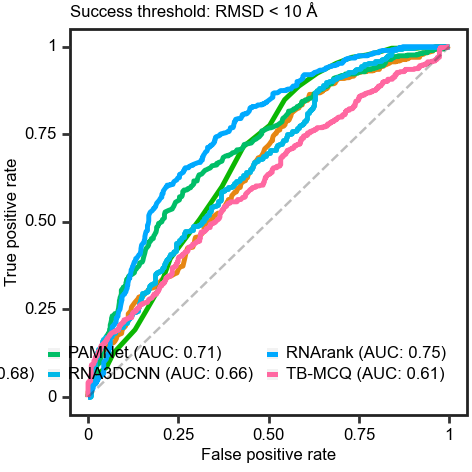

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.36 x 2.36 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/ROC_deep_learning_metrics_LDDT_as_label.pdf


In [11]:
# -------------------------
# Analysis settings
# -------------------------
# -------------------------

# Input / Output
# -------------------------
OUT_PDF = Path("../figures/ROC_deep_learning_metrics_LDDT_as_label.pdf")

# Success definition used in the manuscript figure
LDDT_SUCCESS_THRESHOLD = 0.5  # Å

# Metrics to evaluate and their direction:
# +1  => higher score = better model
# -1  => lower score = better model (we multiply by -1 so higher=better for ROC)
METRICS = [
    ("LociPARSE", +1),
    ("RNArank", +1),
    ("RNA3DCNN", -1),
    ("ARES", -1),
    ("TB-MCQ", -1),
    ("PAMNet", -1),
]


def load_data() -> pd.DataFrame:
    """Load and merge the benchmark metric tables."""
    df1 = pd.read_csv(DATASET1, index_col=0)
    df2 = pd.read_csv(DATASET2, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    # Standardize column names for plotting (optional but helps consistency)
    df = df.rename(columns=COLUMN_RENAME)

    return df


def build_roc_long_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute ROC curve points for each metric and return a long-form table.

    Output columns:
      - fpr, tpr: ROC curve coordinates
      - Metric: legend label with AUC (e.g., "LociPARSE (AUC: 0.87)")
      - MetricName: raw metric name (without AUC), useful for ordering/colors
    """
    # Define binary labels: success if RMSD < threshold
    if "RMSD" not in df.columns:
        raise KeyError("Column 'RMSD' not found. It is required to define the success label.")

    df = df.copy()
    df["label"] = (df["lddt"] > LDDT_SUCCESS_THRESHOLD).astype(int)

    rows = []
    metric_order = []

    for metric_name, direction in METRICS:
        if metric_name not in df.columns:
            print(f"[Warning] Missing metric column '{metric_name}'. Skipping.")
            continue

        sub = df[["label", metric_name]].dropna()
        if sub.shape[0] < 2:
            print(f"[Warning] Not enough non-missing samples for '{metric_name}'. Skipping.")
            continue

        y_true = sub["label"].to_numpy()
        # Make "higher is better" for ROC
        y_score = sub[metric_name].to_numpy() * direction

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        legend_label = f"{metric_name} (AUC: {roc_auc:.2f})"
        metric_order.append(metric_name)

        for x, y in zip(fpr, tpr):
            rows.append({"fpr": x, "tpr": y, "Metric": legend_label, "MetricName": metric_name})

    roc_df = pd.DataFrame(rows)

    # Ensure legend ordering is stable and consistent with METRICS list
    roc_df["MetricName"] = pd.Categorical(roc_df["MetricName"], categories=metric_order, ordered=True)

    return roc_df


def plot_roc(roc_df: pd.DataFrame):
    """
    Create ROC plot (plotnine) and return the ggplot object.
    """
    # Diagonal (random classifier)
    diag = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

    # Colors: align with the metric order actually present in roc_df
    present_metrics = list(roc_df["MetricName"].cat.categories)
    colors = COLOR_LIST[: len(present_metrics)]

    p = (
        ggplot()
        + geom_line(roc_df, aes(x="fpr", y="tpr", group="Metric", color="Metric"), size=1)
        + geom_line(diag, aes(x="x", y="y"), linetype="dashed", alpha=0.3, color=BLACK)
        + theme(
            figure_size=FIGSIZE_IN,
            panel_background=element_rect(fill=GRAY, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0, color=BLACK),
            panel_grid_minor=element_line(size=0.3, alpha=0, color=BLACK),
            panel_border=element_rect(color=BLACK, size=1),
            axis_text=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_x=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_y=element_text(size=FONTSIZE, family=FONT, color="black"),
            plot_title=element_text(size=FONTSIZE, family=FONT, color="black"),
            legend_title=element_text(size=FONTSIZE, family=FONT),
            legend_text=element_text(size=FONTSIZE, family=FONT),
            legend_background=element_rect(size=0.5, alpha=0),
            # Legend inside panel (matches your original layout)
            legend_position=(0.30, 0.25),
            legend_key_size=4,
        )
        + labs(x="False positive rate", y="True positive rate")
        + ggtitle(f"Success threshold: RMSD < {RMSD_SUCCESS_THRESHOLD:g} Å")
        + scale_color_manual(values=colors)
    )

    return p


def main():
    df = load_data()
    roc_df = build_roc_long_table(df)
    if roc_df.empty:
        raise RuntimeError("No ROC curves were generated (check missing columns or data).")

    p = plot_roc(roc_df)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF))


if __name__ == "__main__":
    main()


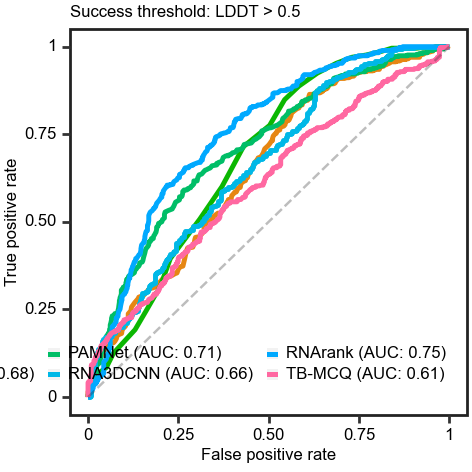

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.36 x 2.36 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/ROC_deep_learning_metrics_LDDT_as_label.pdf


In [13]:
# -------------------------
# Analysis settings
# -------------------------
# -------------------------

# Input / Output
# -------------------------
OUT_PDF = Path("../figures/ROC_deep_learning_metrics_LDDT_as_label.pdf")

# Success definition used in the manuscript figure
LDDT_SUCCESS_THRESHOLD = 0.5  # Å

# Metrics to evaluate and their direction:
# +1  => higher score = better model
# -1  => lower score = better model (we multiply by -1 so higher=better for ROC)
METRICS = [
    ("LociPARSE", +1),
    ("RNArank", +1),
    ("RNA3DCNN", -1),
    ("ARES", -1),
    ("TB-MCQ", -1),
    ("PAMNet", -1),
]


def load_data() -> pd.DataFrame:
    """Load and merge the benchmark metric tables."""
    df1 = pd.read_csv(DATASET1, index_col=0)
    df2 = pd.read_csv(DATASET2, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    # Standardize column names for plotting (optional but helps consistency)
    df = df.rename(columns=COLUMN_RENAME)

    return df


def build_roc_long_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute ROC curve points for each metric and return a long-form table.

    Output columns:
      - fpr, tpr: ROC curve coordinates
      - Metric: legend label with AUC (e.g., "LociPARSE (AUC: 0.87)")
      - MetricName: raw metric name (without AUC), useful for ordering/colors
    """
    # Define binary labels: success if RMSD < threshold
    if "RMSD" not in df.columns:
        raise KeyError("Column 'RMSD' not found. It is required to define the success label.")

    df = df.copy()
    df["label"] = (df["lddt"] > LDDT_SUCCESS_THRESHOLD).astype(int)

    rows = []
    metric_order = []

    for metric_name, direction in METRICS:
        if metric_name not in df.columns:
            print(f"[Warning] Missing metric column '{metric_name}'. Skipping.")
            continue

        sub = df[["label", metric_name]].dropna()
        if sub.shape[0] < 2:
            print(f"[Warning] Not enough non-missing samples for '{metric_name}'. Skipping.")
            continue

        y_true = sub["label"].to_numpy()
        # Make "higher is better" for ROC
        y_score = sub[metric_name].to_numpy() * direction

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        legend_label = f"{metric_name} (AUC: {roc_auc:.2f})"
        metric_order.append(metric_name)

        for x, y in zip(fpr, tpr):
            rows.append({"fpr": x, "tpr": y, "Metric": legend_label, "MetricName": metric_name})

    roc_df = pd.DataFrame(rows)

    # Ensure legend ordering is stable and consistent with METRICS list
    roc_df["MetricName"] = pd.Categorical(roc_df["MetricName"], categories=metric_order, ordered=True)

    return roc_df


def plot_roc(roc_df: pd.DataFrame):
    """
    Create ROC plot (plotnine) and return the ggplot object.
    """
    # Diagonal (random classifier)
    diag = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

    # Colors: align with the metric order actually present in roc_df
    present_metrics = list(roc_df["MetricName"].cat.categories)
    colors = COLOR_LIST[: len(present_metrics)]

    p = (
        ggplot()
        + geom_line(roc_df, aes(x="fpr", y="tpr", group="Metric", color="Metric"), size=1)
        + geom_line(diag, aes(x="x", y="y"), linetype="dashed", alpha=0.3, color=BLACK)
        + theme(
            figure_size=FIGSIZE_IN,
            panel_background=element_rect(fill=GRAY, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0, color=BLACK),
            panel_grid_minor=element_line(size=0.3, alpha=0, color=BLACK),
            panel_border=element_rect(color=BLACK, size=1),
            axis_text=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_x=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_y=element_text(size=FONTSIZE, family=FONT, color="black"),
            plot_title=element_text(size=FONTSIZE, family=FONT, color="black"),
            legend_title=element_text(size=FONTSIZE, family=FONT),
            legend_text=element_text(size=FONTSIZE, family=FONT),
            legend_background=element_rect(size=0.5, alpha=0),
            # Legend inside panel (matches your original layout)
            legend_position=(0.30, 0.25),
            legend_key_size=4,
        )
        + labs(x="False positive rate", y="True positive rate")
        + ggtitle(f"Success threshold: LDDT > {LDDT_SUCCESS_THRESHOLD:g}")
        + scale_color_manual(values=colors)
    )

    return p


def main():
    df = load_data()
    roc_df = build_roc_long_table(df)
    if roc_df.empty:
        raise RuntimeError("No ROC curves were generated (check missing columns or data).")

    p = plot_roc(roc_df)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF))


if __name__ == "__main__":
    main()


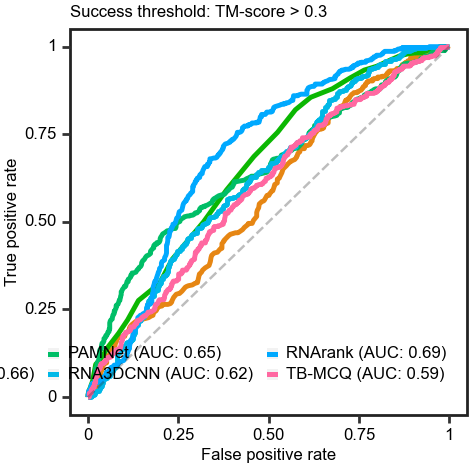

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.36 x 2.36 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/ROC_deep_learning_metrics_TM_score_as_label.pdf


In [16]:
# -------------------------
# Analysis settings
# -------------------------
# -------------------------

# Input / Output
# -------------------------
OUT_PDF = Path("../figures/ROC_deep_learning_metrics_TM_score_as_label.pdf")

# Success definition used in the manuscript figure
TM_SUCCESS_THRESHOLD = 0.3  # Å

# Metrics to evaluate and their direction:
# +1  => higher score = better model
# -1  => lower score = better model (we multiply by -1 so higher=better for ROC)
METRICS = [
    ("LociPARSE", +1),
    ("RNArank", +1),
    ("RNA3DCNN", -1),
    ("ARES", -1),
    ("TB-MCQ", -1),
    ("PAMNet", -1),
]


def load_data() -> pd.DataFrame:
    """Load and merge the benchmark metric tables."""
    df1 = pd.read_csv(DATASET1, index_col=0)
    df2 = pd.read_csv(DATASET2, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    # Standardize column names for plotting (optional but helps consistency)
    df = df.rename(columns=COLUMN_RENAME)

    return df


def build_roc_long_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute ROC curve points for each metric and return a long-form table.

    Output columns:
      - fpr, tpr: ROC curve coordinates
      - Metric: legend label with AUC (e.g., "LociPARSE (AUC: 0.87)")
      - MetricName: raw metric name (without AUC), useful for ordering/colors
    """
    # Define binary labels: success if RMSD < threshold
    if "RMSD" not in df.columns:
        raise KeyError("Column 'RMSD' not found. It is required to define the success label.")

    df = df.copy()
    df["label"] = (df["TM-score"] > TM_SUCCESS_THRESHOLD).astype(int)

    rows = []
    metric_order = []

    for metric_name, direction in METRICS:
        if metric_name not in df.columns:
            print(f"[Warning] Missing metric column '{metric_name}'. Skipping.")
            continue

        sub = df[["label", metric_name]].dropna()
        if sub.shape[0] < 2:
            print(f"[Warning] Not enough non-missing samples for '{metric_name}'. Skipping.")
            continue

        y_true = sub["label"].to_numpy()
        # Make "higher is better" for ROC
        y_score = sub[metric_name].to_numpy() * direction

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        legend_label = f"{metric_name} (AUC: {roc_auc:.2f})"
        metric_order.append(metric_name)

        for x, y in zip(fpr, tpr):
            rows.append({"fpr": x, "tpr": y, "Metric": legend_label, "MetricName": metric_name})

    roc_df = pd.DataFrame(rows)

    # Ensure legend ordering is stable and consistent with METRICS list
    roc_df["MetricName"] = pd.Categorical(roc_df["MetricName"], categories=metric_order, ordered=True)

    return roc_df


def plot_roc(roc_df: pd.DataFrame):
    """
    Create ROC plot (plotnine) and return the ggplot object.
    """
    # Diagonal (random classifier)
    diag = pd.DataFrame({"x": [0, 1], "y": [0, 1]})

    # Colors: align with the metric order actually present in roc_df
    present_metrics = list(roc_df["MetricName"].cat.categories)
    colors = COLOR_LIST[: len(present_metrics)]

    p = (
        ggplot()
        + geom_line(roc_df, aes(x="fpr", y="tpr", group="Metric", color="Metric"), size=1)
        + geom_line(diag, aes(x="x", y="y"), linetype="dashed", alpha=0.3, color=BLACK)
        + theme(
            figure_size=FIGSIZE_IN,
            panel_background=element_rect(fill=GRAY, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0, color=BLACK),
            panel_grid_minor=element_line(size=0.3, alpha=0, color=BLACK),
            panel_border=element_rect(color=BLACK, size=1),
            axis_text=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_x=element_text(size=FONTSIZE, family=FONT, color="black"),
            axis_title_y=element_text(size=FONTSIZE, family=FONT, color="black"),
            plot_title=element_text(size=FONTSIZE, family=FONT, color="black"),
            legend_title=element_text(size=FONTSIZE, family=FONT),
            legend_text=element_text(size=FONTSIZE, family=FONT),
            legend_background=element_rect(size=0.5, alpha=0),
            # Legend inside panel (matches your original layout)
            legend_position=(0.30, 0.25),
            legend_key_size=4,
        )
        + labs(x="False positive rate", y="True positive rate")
        + ggtitle(f"Success threshold: TM-score > {TM_SUCCESS_THRESHOLD:g}")
        + scale_color_manual(values=colors)
    )

    return p


def main():
    df = load_data()
    roc_df = build_roc_long_table(df)
    if roc_df.empty:
        raise RuntimeError("No ROC curves were generated (check missing columns or data).")

    p = plot_roc(roc_df)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF))


if __name__ == "__main__":
    main()
